In [ ]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label


class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [5]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [6]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    in_mem=True,
)
########################################################################
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [7]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-99.1660, dtype=torch.float64) tensor(121.0414, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [8]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

# Get CSP Weights

In [9]:
from cspnn.csp import CSP as CSP_base

In [10]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

csp = CSP_base(list(range(1, 5)), num_bands=1, num_windows=1)

In [11]:
signale = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signale.append(sig)
    label.append(lbl["label"])
signale = torch.vstack(signale)
label = torch.stack(label)

  0%|          | 0/2592 [00:00<?, ?it/s]

In [30]:
signale.size(), label.size()

(torch.Size([2592, 22, 1, 1, 1001]), torch.Size([2592]))

In [31]:
weights = csp.calculate_weights(
    signals=signale.cpu().detach().numpy(), labels=label.cpu().detach().numpy()
)

In [32]:
weights.keys()

dict_keys(['label-1_band-0_window-0', 'label-2_band-0_window-0', 'label-3_band-0_window-0', 'label-4_band-0_window-0'])

## Model

In [16]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [17]:
import torch.optim as optim

In [18]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [37]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        csp_pow: bool = True,
        signal_len: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.csp_pow = csp_pow
        if not self.csp_pow:
            self.signal_len = signal_len
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            csp_pow=csp_pow,
            mode=self.mode,
        )

        if self.csp_pow:
            csp_feature_size = (
                self.num_bands * self.num_windows * self.num_labels * self.num_features
            )
        else:
            # csp_feature_size = (
            #     self.num_bands
            #     * self.num_windows
            #     * self.num_labels
            #     * self.num_features
            #     * self.signal_len
            # )
            csp_feature_size = (
                self.num_bands
                * self.num_windows
                * self.num_labels
                * self.num_features
                * 51
            )

        self.avgp1 = nn.AvgPool1d(39, stride=19)

        self.fc2 = nn.Linear(csp_feature_size, 32)
        # self.fc1 = nn.Linear(256, 128)
        self.fc = nn.Linear(32, 4)

    def forward(self, x):
        csp = self.conv1(x)
        # print(csp.size())

        # features = csp.reshape(
        #     (
        #         -1,
        #         self.num_bands * self.num_windows * self.num_labels * self.num_features,
        #     )
        # )

        csp_pooled = self.avgp1(csp.reshape((-1, 4 * 22, self.signal_len)))
        # print(csp_pooled.size())
        features = torch.flatten(csp_pooled, start_dim=1)

        x = features
        x = torch.tanh(self.fc2(x))
        # x = F.dropout(x, 0.5)
        # x = torch.tanh(self.fc1(x))
        x = F.dropout(x, 0.5)

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22,
    num_features=22,
    num_bands=1,
    num_windows=1,
    num_labels=4,
    csp_pow=False,
    signal_len=1001,
    mode="constant",
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.00)
# optimizer = optim.SGD(
#     net.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0
# )

# optimizer = optim.SGD(
#     [
#         {"params": net.conv1.parameters()},
#         {"params": net.fc2.parameters(), "weight_decay": 5e-3},
#         # {"params": net.fc1.parameters(), "weight_decay": 5e-3},
#         {"params": net.fc.parameters()},
#     ],
#     lr=0.001,
#     momentum=0.9,
#     nesterov=True,
#     weight_decay=0,
# )

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [38]:
signals = torch.empty((10, 22, 1, 1, 1001), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22, 1001]))

In [39]:
net.conv1.load_csp_weights(weights=weights, csp_template=csp.template)

In [40]:
net = net.to("cuda")

## Train Loop

In [41]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "train_kappa": [],
    "test_kappa": [],
    "train_fmeasure": [],
    "test_fmeasure": [],
    "lr": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    # params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    params = ["acc", "kappa", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])
    history["train_fmeasure"].append(tr[2])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])
    history["test_fmeasure"].append(ev[2])


Epoch  0


81it [00:02, 37.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.4002695716457603


Train -  [0.2770061728395062, 0.03600823045267487, 0.2770061728395062, tensor(1.3811)]
Validation -  [0.2770061728395062, 0.03600823045267487, 0.2770061728395062, tensor(1.3905)]

Epoch  1


81it [00:02, 38.53it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3888552748126748


Train -  [0.30169753086419754, 0.06893004115226342, 0.30169753086419754, tensor(1.3741)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3962)]

Epoch  2


81it [00:02, 38.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3773193786173692


Train -  [0.30787037037037035, 0.0771604938271605, 0.30787037037037035, tensor(1.3756)]
Validation -  [0.26080246913580246, 0.014403292181069949, 0.26080246913580246, tensor(1.3957)]

Epoch  3


81it [00:02, 40.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3743604863131489


Train -  [0.3275462962962963, 0.10339506172839508, 0.3275462962962963, tensor(1.3650)]
Validation -  [0.25462962962962965, 0.006172839506172867, 0.25462962962962965, tensor(1.4058)]

Epoch  4


81it [00:01, 42.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3752474475789953


Train -  [0.3074845679012346, 0.0766460905349794, 0.3074845679012346, tensor(1.3746)]
Validation -  [0.25925925925925924, 0.012345679012345734, 0.25925925925925924, tensor(1.4043)]

Epoch  5


81it [00:02, 37.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.374584769025261


Train -  [0.30787037037037035, 0.0771604938271605, 0.30787037037037035, tensor(1.3720)]
Validation -  [0.2631172839506173, 0.017489711934156382, 0.2631172839506173, tensor(1.4049)]

Epoch  6


81it [00:02, 39.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3726706210477853


Train -  [0.32175925925925924, 0.095679012345679, 0.32175925925925924, tensor(1.3675)]
Validation -  [0.25617283950617287, 0.008230452674897082, 0.25617283950617287, tensor(1.4069)]

Epoch  7


81it [00:02, 38.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3807441261079576


Train -  [0.3221450617283951, 0.0961934156378601, 0.3221450617283951, tensor(1.3671)]
Validation -  [0.26157407407407407, 0.015432098765432056, 0.26157407407407407, tensor(1.4035)]

Epoch  8


81it [00:02, 38.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3720648480050357


Train -  [0.32330246913580246, 0.09773662551440332, 0.32330246913580246, tensor(1.3657)]
Validation -  [0.24614197530864199, -0.005144032921810648, 0.24614197530864199, tensor(1.4115)]

Epoch  9


81it [00:01, 40.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3714045977886813


Train -  [0.3317901234567901, 0.10905349794238683, 0.3317901234567901, tensor(1.3615)]
Validation -  [0.26697530864197533, 0.02263374485596703, 0.26697530864197533, tensor(1.4039)]

Epoch  10


81it [00:02, 39.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3659463414439448


Train -  [0.33101851851851855, 0.10802469135802473, 0.33101851851851855, tensor(1.3627)]
Validation -  [0.2743055555555556, 0.03240740740740744, 0.2743055555555556, tensor(1.4027)]

Epoch  11


81it [00:02, 40.20it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.368124986872261


In [43]:
{k: history[k][-1] for k in history.keys()}

{'train_loss': tensor(1.3102),
 'test_loss': tensor(1.4177),
 'train_acc': 0.39969135802469136,
 'test_acc': 0.2654320987654321,
 'train_kappa': 0.19958847736625518,
 'test_kappa': 0.020576131687242816,
 'train_fmeasure': 0.3996913580246914,
 'test_fmeasure': 0.2654320987654321,
 'lr': 1.0000000000000012e-21}

In [44]:
idx = np.argmax(history["train_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.2919),
 'test_loss': tensor(1.4239),
 'train_acc': 0.42824074074074076,
 'test_acc': 0.25540123456790126,
 'train_kappa': 0.23765432098765427,
 'test_kappa': 0.007201646090534974,
 'train_fmeasure': 0.42824074074074076,
 'test_fmeasure': 0.25540123456790126,
 'lr': 1.000000000000001e-17}

In [45]:
import matplotlib.pyplot as plt

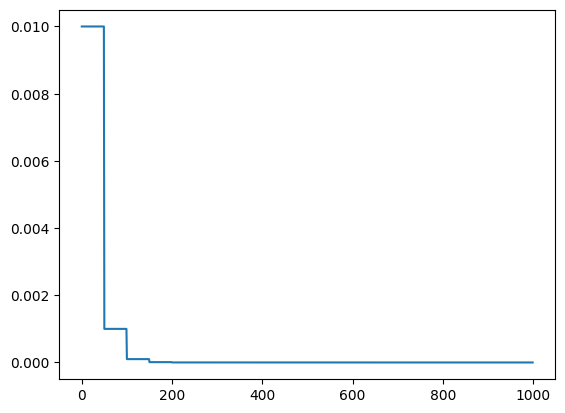

In [46]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

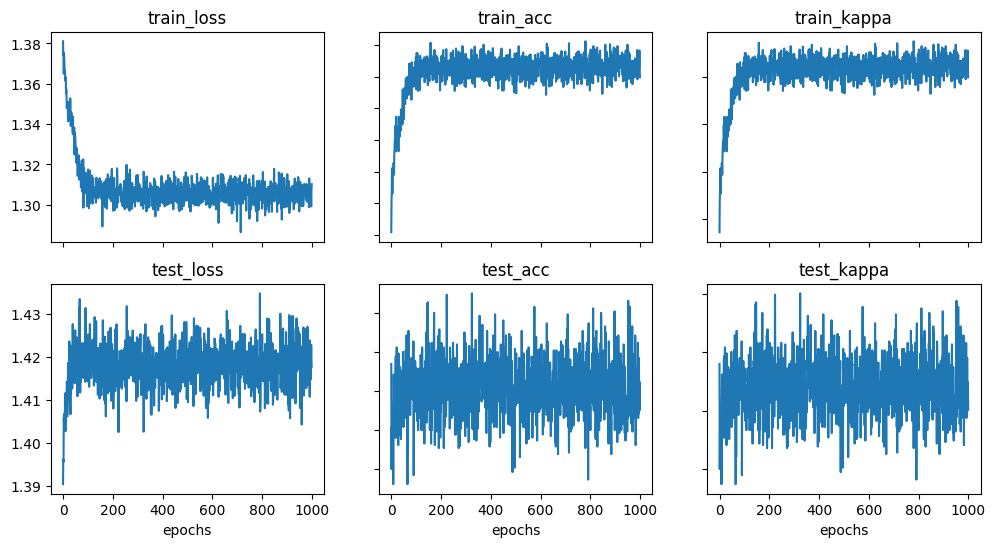

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

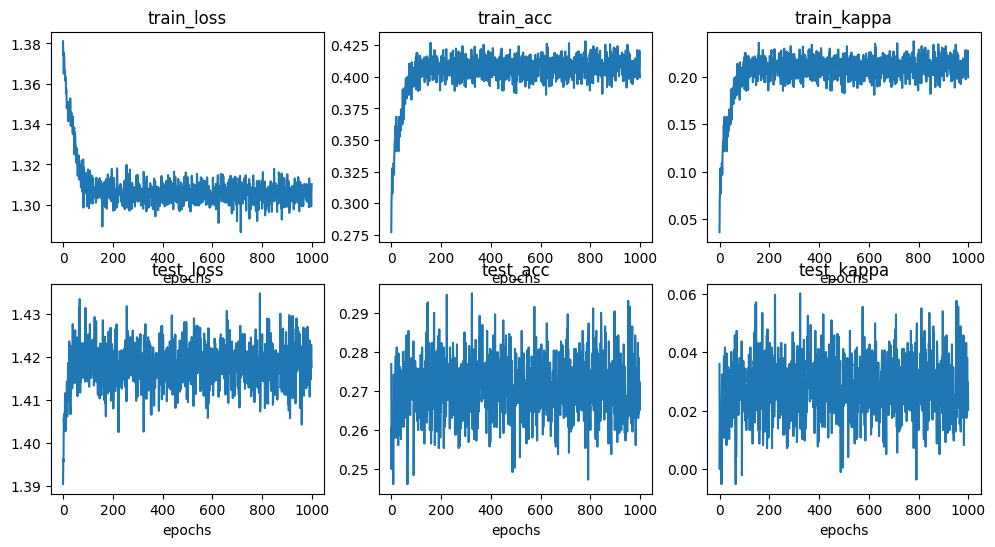

In [48]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [36]:
a = 0.3549382716049383
print(f"{a:.2}")

0.35
